In [1]:
!pip install beautifulsoup4 requests pandas arabic-reshaper python-bidi

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random

class ImprovedArabicScraper:
    def __init__(self, topic="technology"):
        self.topic = topic
        self.data = []
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }
    
    def scrape_article_links(self, base_url, max_links=20):
        """Extract article links from a page"""
        try:
            response = requests.get(base_url, headers=self.headers, timeout=10)
            response.encoding = 'utf-8'
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Find all article links
            links = []
            for a in soup.find_all('a', href=True):
                href = a['href']
                # Make absolute URL
                if href.startswith('/'):
                    href = base_url.rstrip('/') + href
                elif not href.startswith('http'):
                    continue
                    
                # Filter relevant links (articles, not categories)
                if any(word in href for word in ['article', 'news', 'story', '20']):
                    if href not in links:
                        links.append(href)
                        
            return links[:max_links]
        except Exception as e:
            print(f"Error extracting links: {e}")
            return []
    
    def scrape_article(self, url):
        """Scrape a single article"""
        try:
            response = requests.get(url, headers=self.headers, timeout=10)
            response.encoding = 'utf-8'
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Try multiple selectors for article content
            text = ""
            
            # Method 1: Find article body
            article = soup.find('article')
            if article:
                paragraphs = article.find_all('p')
                text = ' '.join([p.get_text().strip() for p in paragraphs])
            
            # Method 2: Find all paragraphs if no article tag
            if not text:
                paragraphs = soup.find_all('p')
                text = ' '.join([p.get_text().strip() for p in paragraphs])
            
            # Clean text
            text = ' '.join(text.split())
            
            return text if len(text) > 100 else None
            
        except Exception as e:
            print(f"Error scraping article: {e}")
            return None
    
    def scrape_from_urls(self, urls, articles_per_url=10):
        """Scrape multiple articles from each URL"""
        for base_url in urls:
            print(f"\n📰 Processing: {base_url}")
            
            # Get article links
            article_links = self.scrape_article_links(base_url, articles_per_url)
            print(f"Found {len(article_links)} article links")
            
            # Scrape each article
            for i, link in enumerate(article_links, 1):
                print(f"  [{i}/{len(article_links)}] Scraping...", end=' ')
                
                text = self.scrape_article(link)
                
                if text and len(text) > 100:
                    score = self.calculate_score(text)
                    self.data.append({
                        'text': text,
                        'score': score,
                        'url': link,
                        'length': len(text.split())
                    })
                    print(f"✓ ({len(text.split())} words, score: {score})")
                else:
                    print("✗ No content")
                
                time.sleep(random.uniform(1, 3))  # Random delay
            
            time.sleep(3)  # Delay between sites
    
    def calculate_score(self, text):
        """Calculate relevance score (0-10)"""
        score = 5.0
        words = text.split()
        
        # Length factor
        if len(words) > 100:
            score += 1
        if len(words) > 300:
            score += 1
        if len(words) > 500:
            score += 0.5
        
        # Technology keywords
        tech_keywords = [
            'تقنية', 'تكنولوجيا', 'ذكاء اصطناعي', 'برمجة', 'حاسوب',
            'إنترنت', 'بيانات', 'رقمي', 'إلكتروني', 'شبكة'
        ]
        keyword_count = sum(1 for kw in tech_keywords if kw in text)
        score += min(keyword_count * 0.4, 2.5)
        
        return round(min(score, 10.0), 1)
    
    def create_synthetic_data(self, n_samples=100):
        """Generate synthetic Arabic text data as fallback"""
        templates = [
            "التكنولوجيا الحديثة تغير {domain} بشكل كبير من خلال {technology}",
            "الذكاء الاصطناعي يساعد في {application} ويحسن {benefit}",
            "تطور {field} يعتمد على {technology} والابتكار المستمر",
            "البيانات الضخمة تساعد {sector} على {action} بشكل أفضل",
            "الأمن السيبراني ضروري لحماية {asset} من {threat}"
        ]
        
        domains = ["الطب", "التعليم", "الصناعة", "التجارة", "الاتصالات"]
        technologies = ["التعلم الآلي", "الحوسبة السحابية", "إنترنت الأشياء"]
        applications = ["التشخيص المبكر", "التحليل السريع", "التنبؤ الدقيق"]
        
        for i in range(n_samples):
            template = random.choice(templates)
            text = template.format(
                domain=random.choice(domains),
                technology=random.choice(technologies),
                application=random.choice(applications),
                benefit="الأداء والكفاءة",
                field="البرمجة",
                sector="الشركات",
                action="اتخاذ القرارات",
                asset="المعلومات الحساسة",
                threat="الهجمات الإلكترونية"
            )
            
            # Add more content
            text += " وهذا يؤدي إلى تحسين كبير في النتائج والإنتاجية."
            
            score = round(random.uniform(6.0, 9.0), 1)
            self.data.append({
                'text': text,
                'score': score,
                'url': 'synthetic',
                'length': len(text.split())
            })
    
    def save_dataset(self, filename='arabic_dataset.csv'):
        if not self.data:
            print("⚠ No data collected!")
            return None
        
        df = pd.DataFrame(self.data)
        df.to_csv(filename, index=False, encoding='utf-8-sig')
        print(f"\n Dataset saved: {len(df)} samples to {filename}")
        print(f"   Average score: {df['score'].mean():.2f}")
        print(f"   Average length: {df['length'].mean():.0f} words")
        return df


# ==================== USAGE ====================

scraper = ImprovedArabicScraper()

# Option 1: Try scraping real articles
print("=" * 60)
print("ATTEMPTING TO SCRAPE REAL ARTICLES")
print("=" * 60)

urls = [
    'https://www.aljazeera.net/technology',
    'https://www.alarabiya.net/technology',
]

scraper.scrape_from_urls(urls, articles_per_url=5)

# Option 2: If scraping didn't work well, add synthetic data
if len(scraper.data) < 50:
    print("\n" + "=" * 60)
    print("ADDING SYNTHETIC DATA (need more samples for training)")
    print("=" * 60)
    current_count = len(scraper.data)
    needed = 100 - current_count
    scraper.create_synthetic_data(needed)
    print(f"Added {needed} synthetic samples")

# Save and display
df = scraper.save_dataset()

if df is not None:
    print("\n" + "=" * 60)
    print("DATASET SUMMARY")
    print("=" * 60)
    print(df.head(10))
    print(f"\nScore distribution:\n{df['score'].describe()}")
    print(f"\nData sources:")
    print(df['url'].value_counts())
else:
    print("Failed to create dataset")


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


ATTEMPTING TO SCRAPE REAL ARTICLES

📰 Processing: https://www.aljazeera.net/technology
Found 5 article links
  [1/5] Scraping... ✓ (28 words, score: 5.0)
  [2/5] Scraping... ✓ (476 words, score: 8.2)
  [3/5] Scraping... ✓ (450 words, score: 8.2)
  [4/5] Scraping... ✓ (232 words, score: 6.4)
  [5/5] Scraping... ✓ (601 words, score: 9.1)

📰 Processing: https://www.alarabiya.net/technology
Found 0 article links

ADDING SYNTHETIC DATA (need more samples for training)
Added 95 synthetic samples

 Dataset saved: 100 samples to arabic_dataset.csv
   Average score: 7.38
   Average length: 34 words

DATASET SUMMARY
                                                text  score  \
0  توج منتخب المغرب بلقب كأس العرب لكرة القدم للم...    5.0   
1  شارِكْ حفظ أفادت شركة آبل بأنها ستسمح بوجود مت...    8.2   
2  شارِكْ حفظ ظهرت كيم يو جونغ شقيقة رئيس كوريا ا...    8.2   
3  شارِكْ حفظ قالت وكالة الأنباء الألمانية إن شرك...    6.4   
4  شارِكْ حفظ على خلاف نبوءات "نهاية الوظائف"، يك...    9.1   
5  الذكا

In [2]:
# Step 2: Arabic Text Preprocessing Pipeline
# Install Arabic NLP libraries
!pip install nltk camel-tools pyarabic -q

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

class ArabicTextPreprocessor:
    def __init__(self):
        try:
            self.arabic_stopwords = set(stopwords.words('arabic'))
        except:
            # Fallback stopwords if NLTK download fails
            self.arabic_stopwords = {
                'في', 'من', 'إلى', 'على', 'هذا', 'هذه', 'ذلك', 'التي', 'الذي',
                'و', 'أو', 'لكن', 'أن', 'إن', 'كان', 'قد', 'لم', 'كل', 'بعض'
            }
        
        # Add custom stopwords
        self.arabic_stopwords.update(['من', 'إلى', 'على', 'في', 'هذا', 'التي'])
        
    def clean_text(self, text):
        """Remove diacritics, numbers, and special characters"""
        if not isinstance(text, str):
            return ""
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+', '', text)
        
        # Remove Arabic diacritics (Tashkeel)
        text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Remove English characters
        text = re.sub(r'[a-zA-Z]+', '', text)
        
        # Remove punctuation except Arabic letters
        text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Normalize Arabic letters
        text = re.sub(r'[إأآا]', 'ا', text)
        text = re.sub(r'ى', 'ي', text)
        text = re.sub(r'ة', 'ه', text)
        text = re.sub(r'ؤ', 'و', text)
        text = re.sub(r'ئ', 'ي', text)
        
        return text
    
    def tokenize(self, text):
        """Tokenize Arabic text"""
        if not text:
            return []
        
        try:
            # Try NLTK tokenization
            tokens = word_tokenize(text)
        except:
            # Fallback: simple split
            tokens = text.split()
        
        return [token.strip() for token in tokens if token.strip()]
    
    def remove_stopwords(self, tokens):
        """Remove Arabic stopwords"""
        return [token for token in tokens 
                if token not in self.arabic_stopwords and len(token) > 1]
    
    def preprocess_pipeline(self, text):
        """Complete preprocessing pipeline"""
        # Clean text
        cleaned = self.clean_text(text)
        
        # Tokenize
        tokens = self.tokenize(cleaned)
        
        # Remove stopwords
        filtered_tokens = self.remove_stopwords(tokens)
        
        # Rejoin tokens
        processed_text = ' '.join(filtered_tokens)
        
        return processed_text, filtered_tokens
    
    def discretize_scores(self, scores, bins=3):
        """Convert continuous scores to discrete classes"""
        # bins=3: Low (0-5), Medium (5-7.5), High (7.5-10)
        if isinstance(scores, pd.Series):
            labels = ['low', 'medium', 'high']
            return pd.cut(scores, bins=bins, labels=labels)
        else:
            # For single value
            if scores < 5:
                return 'low'
            elif scores < 7.5:
                return 'medium'
            else:
                return 'high'


def preprocess_dataset(df):
    """Preprocess entire dataset"""
    print("Starting preprocessing pipeline...")
    
    preprocessor = ArabicTextPreprocessor()
    
    # Apply preprocessing
    results = df['text'].apply(lambda x: preprocessor.preprocess_pipeline(x))
    
    df['processed_text'] = results.apply(lambda x: x[0])
    df['tokens'] = results.apply(lambda x: x[1])
    
    # Discretize scores (optional for classification)
    df['score_category'] = preprocessor.discretize_scores(df['score'])
    
    # Calculate sequence lengths
    df['seq_length'] = df['tokens'].apply(len)
    
    # Remove empty texts
    df = df[df['seq_length'] > 0].reset_index(drop=True)
    
    print(f"   Preprocessing complete!")
    print(f"   Total samples: {len(df)}")
    print(f"   Average sequence length: {df['seq_length'].mean():.1f} tokens")
    print(f"   Min length: {df['seq_length'].min()}, Max length: {df['seq_length'].max()}")
    
    return df


# ==================== USAGE WITH THE NEW SCRAPER ====================

# Load the dataset from the improved scraper
try:
    df = pd.read_csv('arabic_dataset.csv', encoding='utf-8-sig')
    print(f"Loaded dataset: {len(df)} samples")
except FileNotFoundError:
    print("Dataset file not found! Run the scraper first.")
    print("Creating a small sample dataset for demonstration...")
    
    # Sample data for testing
    df = pd.DataFrame({
        'text': [
            'التكنولوجيا الحديثة تغير العالم بسرعة كبيرة ومع التطورات المستمرة في مجال الذكاء الاصطناعي',
            'الذكاء الاصطناعي يحدث ثورة في مجال الطب والرعاية الصحية من خلال التشخيص المبكر',
            'البرمجة مهارة أساسية في العصر الحديث ويجب على الجميع تعلم أساسياتها',
            'علم البيانات والتحليلات تساعد الشركات على اتخاذ قرارات أفضل وأكثر دقة',
            'الأمن السيبراني أصبح ضرورة ملحة في عالم متصل بالإنترنت بشكل كامل'
        ],
        'score': [7.5, 8.0, 6.5, 7.8, 7.2],
        'url': ['sample'] * 5,
        'length': [0] * 5
    })

# Display original data
print("\n" + "="*60)
print("ORIGINAL DATA SAMPLE")
print("="*60)
print(df[['text', 'score']].head())

# Preprocess the dataset
df_processed = preprocess_dataset(df)

# Display preprocessed data
print("\n" + "="*60)
print("PREPROCESSED DATA SAMPLE")
print("="*60)
print(df_processed[['text', 'processed_text', 'score', 'score_category', 'seq_length']].head())

# Save preprocessed dataset
df_processed.to_csv('arabic_dataset_preprocessed.csv', index=False, encoding='utf-8-sig')
print(f"\nPreprocessed dataset saved to: arabic_dataset_preprocessed.csv")

# Display statistics
print("\n" + "="*60)
print("PREPROCESSING STATISTICS")
print("="*60)
print(f"Score distribution:")
print(df_processed['score_category'].value_counts())
print(f"\nSequence length statistics:")
print(df_processed['seq_length'].describe())

# Display token examples
print("\n" + "="*60)
print("TOKEN EXAMPLES (First 3 samples)")
print("="*60)
for idx in range(min(3, len(df_processed))):
    print(f"\nSample {idx+1}:")
    print(f"Original: {df_processed.iloc[idx]['text'][:100]}...")
    print(f"Tokens: {df_processed.iloc[idx]['tokens'][:10]}...")
    print(f"Score: {df_processed.iloc[idx]['score']} ({df_processed.iloc[idx]['score_category']})")
    print(f"Length: {df_processed.iloc[idx]['seq_length']} tokens")


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Loaded dataset: 100 samples

ORIGINAL DATA SAMPLE
                                                text  score
0  توج منتخب المغرب بلقب كأس العرب لكرة القدم للم...    5.0
1  شارِكْ حفظ أفادت شركة آبل بأنها ستسمح بوجود مت...    8.2
2  شارِكْ حفظ ظهرت كيم يو جونغ شقيقة رئيس كوريا ا...    8.2
3  شارِكْ حفظ قالت وكالة الأنباء الألمانية إن شرك...    6.4
4  شارِكْ حفظ على خلاف نبوءات "نهاية الوظائف"، يك...    9.1
Starting preprocessing pipeline...
   Preprocessing complete!
   Total samples: 100
   Average sequence length: 29.6 tokens
   Min length: 15, Max length: 517

PREPROCESSED DATA SAMPLE
                                                text  \
0  توج منتخب المغرب بلقب كأس العرب لكرة القدم للم...   
1  شارِكْ حفظ أفادت شركة آبل بأنها ستسمح بوجود مت...   
2  شارِكْ حفظ ظهرت كيم يو جونغ شقيقة رئيس كوريا ا...   
3  شارِكْ حفظ قالت وكالة الأنباء الألمانية إن شرك...   
4  شارِكْ حفظ على خلاف نبوءات "نهاية الوظائف"، يك...   

                                      processed_text  score score_ca


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


LOADING DATA
Loaded 100 samples

BUILDING VOCABULARY
Vocabulary size: 1064 words
Train samples: 80
Test samples: 20

HYPERPARAMETERS
Vocabulary Size: 1064
Embedding Dim: 128
Hidden Dim: 256
Layers: 2
Dropout: 0.3
Learning Rate: 0.001
Epochs: 30
Using device: cpu

Training RNN
Epoch 10/30 | Train Loss: 35.4688 | Val Loss: 39.3255
Epoch 20/30 | Train Loss: 40.9157 | Val Loss: 38.9361
Epoch 30/30 | Train Loss: 36.4548 | Val Loss: 37.7738
Best Val Loss: 1.0680

RNN - Test Results
MSE:  36.8734
RMSE: 6.0723
MAE:  5.0840
R²:   -34.0017
Using device: cpu

Training BiRNN
Epoch 10/30 | Train Loss: 0.8639 | Val Loss: 0.9251
Epoch 20/30 | Train Loss: 0.8402 | Val Loss: 0.8738
Epoch 30/30 | Train Loss: 0.9474 | Val Loss: 0.9012
Best Val Loss: 0.8552

BiRNN - Test Results
MSE:  0.9337
RMSE: 0.9663
MAE:  0.7638
R²:   0.1137
Using device: cpu

Training GRU
Epoch 10/30 | Train Loss: 0.8891 | Val Loss: 0.9623
Epoch 20/30 | Train Loss: 0.9516 | Val Loss: 0.9620
Epoch 30/30 | Train Loss: 0.9705 | Val Los

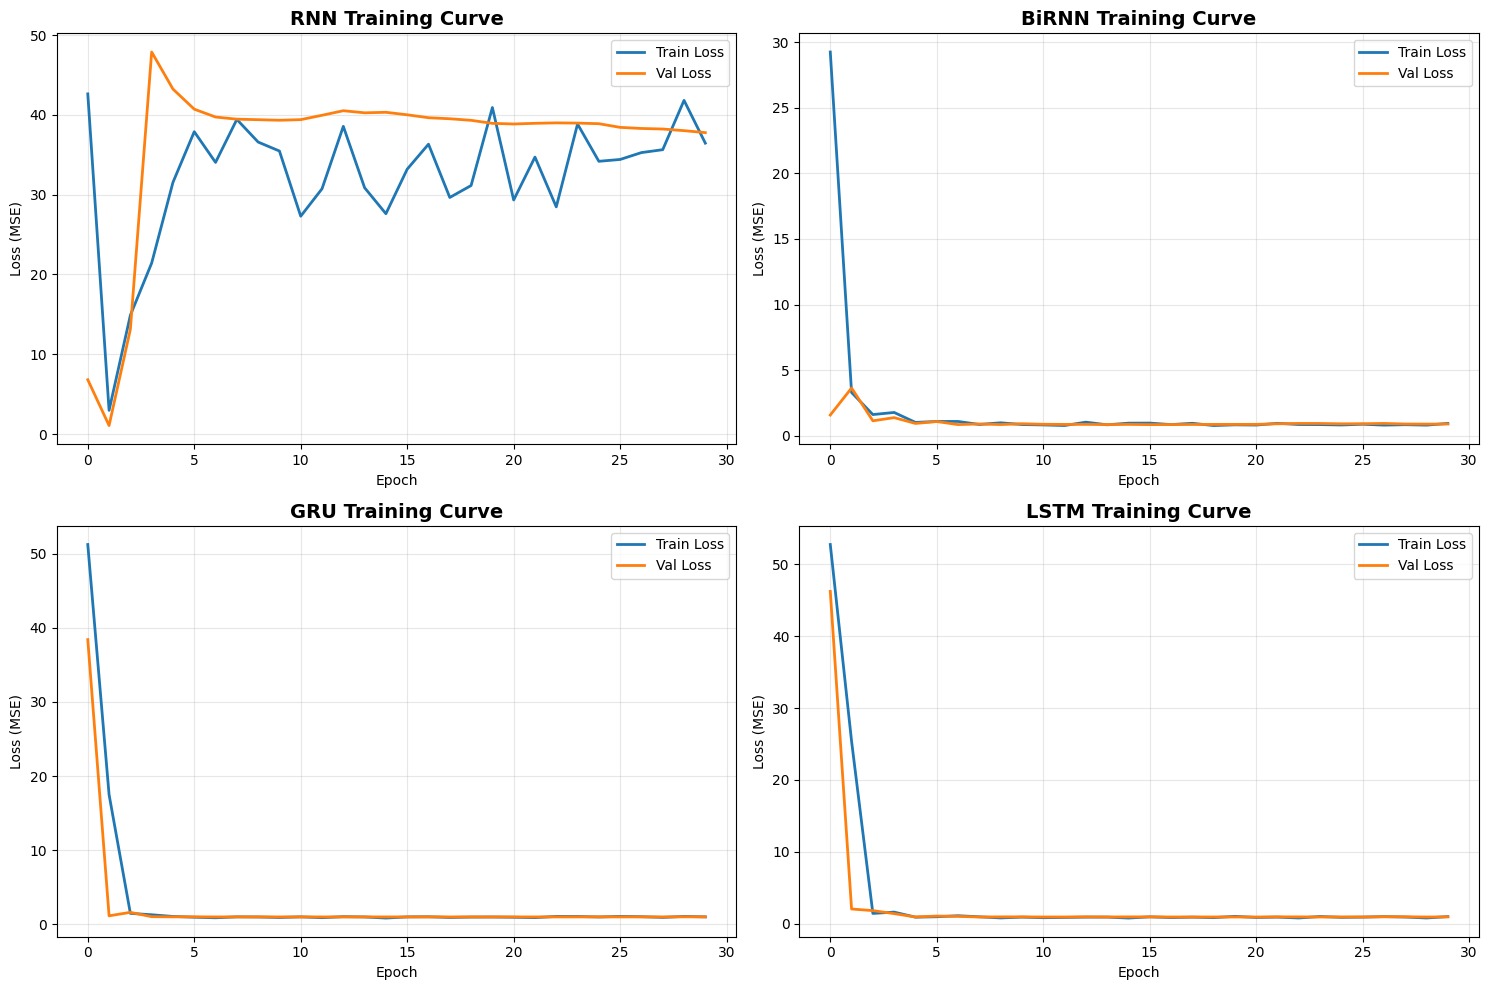

Model comparison saved as 'model_comparison.png'


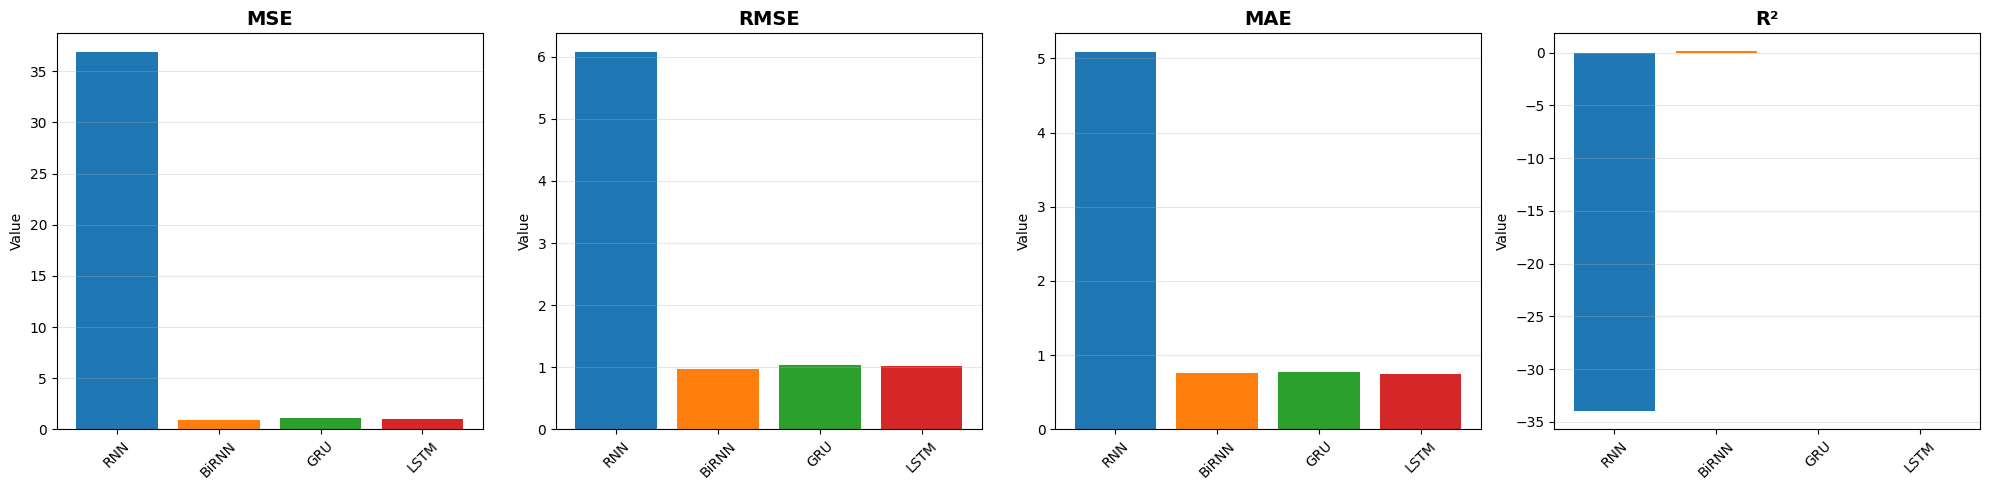


Results saved to 'model_results.csv'

FINAL RESULTS SUMMARY
model       mse     rmse      mae         r2
  RNN 36.873368 6.072345 5.083952 -34.001652
BiRNN  0.933741 0.966303 0.763795   0.113656
  GRU  1.079890 1.039177 0.777476  -0.025074
 LSTM  1.055225 1.027241 0.739508  -0.001661

Best Model: BiRNN (RMSE: 0.9663)


In [3]:
# Step 3: Train RNN, Bidirectional RNN, GRU, and LSTM Models
!pip install matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ==================== Dataset Class ====================

class ArabicTextDataset(Dataset):
    def __init__(self, texts, scores, vocab, max_length=100):
        self.texts = texts
        self.scores = scores
        self.vocab = vocab
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        score = self.scores[idx]
        
        # Convert text to indices
        tokens = text.split() if isinstance(text, str) else []
        indices = [self.vocab.get(token, self.vocab['<UNK>']) 
                   for token in tokens]
        
        # Pad or truncate
        if len(indices) < self.max_length:
            indices += [self.vocab['<PAD>']] * (self.max_length - len(indices))
        else:
            indices = indices[:self.max_length]
        
        return torch.tensor(indices, dtype=torch.long), torch.tensor(score, dtype=torch.float32)

# ==================== Vocabulary Builder ====================

def build_vocab(texts, min_freq=1):
    """Build vocabulary from texts"""
    word_freq = {}
    for text in texts:
        if isinstance(text, str):
            for word in text.split():
                word_freq[word] = word_freq.get(word, 0) + 1
    
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    for word, freq in sorted(word_freq.items()):
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
    
    print(f"Vocabulary size: {len(vocab)} words")
    return vocab

# ==================== Model Architectures ====================

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=2, dropout=0.3):
        super(RNNModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, 
                          batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, hidden = self.rnn(embedded)
        # Use last hidden state
        hidden = self.dropout(hidden[-1])
        return self.fc(hidden).squeeze()

class BiRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=2, dropout=0.3):
        super(BiRNNModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, 
                          batch_first=True, dropout=dropout if n_layers > 1 else 0, 
                          bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, hidden = self.rnn(embedded)
        # Concatenate forward and backward hidden states
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        hidden = self.dropout(hidden)
        return self.fc(hidden).squeeze()

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=2, dropout=0.3):
        super(GRUModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, 
                          batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, hidden = self.gru(embedded)
        hidden = self.dropout(hidden[-1])
        return self.fc(hidden).squeeze()

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        return self.fc(hidden).squeeze()

# ==================== Training Function ====================

def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, model_name="Model"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = model.to(device)
    
    criterion = nn.MSELoss()  # For regression task
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for texts, scores in train_loader:
            texts, scores = texts.to(device), scores.to(device)
            
            optimizer.zero_grad()
            predictions = model(texts)
            loss = criterion(predictions, scores)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for texts, scores in val_loader:
                texts, scores = texts.to(device), scores.to(device)
                predictions = model(texts)
                loss = criterion(predictions, scores)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{model_name}_best.pth')
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    
    print(f"Best Val Loss: {best_val_loss:.4f}")
    return train_losses, val_losses

# ==================== Evaluation Function ====================

def evaluate_model(model, test_loader, model_name="Model"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for texts, scores in test_loader:
            texts, scores = texts.to(device), scores.to(device)
            predictions = model(texts)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(scores.cpu().numpy())
    
    # Calculate metrics
    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)
    
    print(f"\n{'='*60}")
    print(f"{model_name} - Test Results")
    print(f"{'='*60}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")
    
    return {
        'model': model_name,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': all_predictions,
        'targets': all_targets
    }

# ==================== Visualization ====================

def plot_training_curves(results_dict):
    """Plot training curves for all models"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (name, losses) in enumerate(results_dict.items()):
        train_losses, val_losses = losses
        axes[idx].plot(train_losses, label='Train Loss', linewidth=2)
        axes[idx].plot(val_losses, label='Val Loss', linewidth=2)
        axes[idx].set_title(f'{name} Training Curve', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel('Loss (MSE)')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    print("Training curves saved as 'training_curves.png'")
    plt.show()

def plot_comparison(eval_results):
    """Plot model comparison"""
    models = [r['model'] for r in eval_results]
    metrics = ['MSE', 'RMSE', 'MAE', 'R²']
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for idx, metric in enumerate(metrics):
        values = [r[metric.lower().replace('²', '2')] for r in eval_results]
        axes[idx].bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        axes[idx].set_title(metric, fontsize=14, fontweight='bold')
        axes[idx].set_ylabel('Value')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    print("Model comparison saved as 'model_comparison.png'")
    plt.show()

# ==================== MAIN EXECUTION ====================

# Load preprocessed data
print("="*60)
print("LOADING DATA")
print("="*60)

try:
    df = pd.read_csv('arabic_dataset_preprocessed.csv', encoding='utf-8-sig')
    print(f"Loaded {len(df)} samples")
except FileNotFoundError:
    print("Preprocessed data not found! Using sample data...")
    df = pd.DataFrame({
        'processed_text': [
            'تكنولوجيا حديثه تغير عالم سرعه كبيره تطورات مستمره مجال ذكاء اصطناعي',
            'ذكاء اصطناعي يحدث ثوره مجال طب رعايه صحيه تشخيص مبكر',
            'برمجه مهاره اساسيه عصر حديث يجب جميع تعلم اساسياتها',
            'علم بيانات تحليلات تساعد شركات اتخاذ قرارات افضل اكثر دقه',
            'امن سيبراني اصبح ضروره ملحه عالم متصل انترنت شكل كامل'
        ] * 20,  # Repeat to get 100 samples
        'score': [7.5, 8.0, 6.5, 7.8, 7.2] * 20
    })

# Build vocabulary
print("\n" + "="*60)
print("BUILDING VOCABULARY")
print("="*60)
vocab = build_vocab(df['processed_text'])
vocab_size = len(vocab)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'].values, 
    df['score'].values, 
    test_size=0.2, 
    random_state=42
)

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Create datasets
train_dataset = ArabicTextDataset(X_train, y_train, vocab, max_length=100)
test_dataset = ArabicTextDataset(X_test, y_test, vocab, max_length=100)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Hyperparameters
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.3
EPOCHS = 30
LR = 0.001

print(f"\n{'='*60}")
print("HYPERPARAMETERS")
print(f"{'='*60}")
print(f"Vocabulary Size: {vocab_size}")
print(f"Embedding Dim: {EMBEDDING_DIM}")
print(f"Hidden Dim: {HIDDEN_DIM}")
print(f"Layers: {N_LAYERS}")
print(f"Dropout: {DROPOUT}")
print(f"Learning Rate: {LR}")
print(f"Epochs: {EPOCHS}")

# Initialize models
models = {
    'RNN': RNNModel(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT),
    'BiRNN': BiRNNModel(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT),
    'GRU': GRUModel(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT),
    'LSTM': LSTMModel(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
}

# Train all models
training_results = {}
eval_results = []

for name, model in models.items():
    train_losses, val_losses = train_model(
        model, train_loader, test_loader, 
        epochs=EPOCHS, lr=LR, model_name=name
    )
    training_results[name] = (train_losses, val_losses)
    
    # Evaluate
    eval_result = evaluate_model(model, test_loader, model_name=name)
    eval_results.append(eval_result)

# Plot results
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)
plot_training_curves(training_results)
plot_comparison(eval_results)

# Save results summary
results_df = pd.DataFrame(eval_results)[['model', 'mse', 'rmse', 'mae', 'r2']]
results_df.to_csv('model_results.csv', index=False)
print("\nResults saved to 'model_results.csv'")

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(results_df.to_string(index=False))

# Find best model
best_model = results_df.loc[results_df['rmse'].idxmin()]
print(f"\nBest Model: {best_model['model']} (RMSE: {best_model['rmse']:.4f})")


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



NOW CALLING run_complete_evaluation()...

RUNNING COMPLETE MODEL EVALUATION

Evaluating RNN

Metrics for RNN:
  MSE: 36.8734
  RMSE: 6.0723
  MAE: 5.0840
  R²: -34.0017
  Correlation: 0.3908
  Accuracy (±1.0): 5.0000
  Accuracy (±0.5): 0.0000
  BLEU-like Score: 0.0000
Saved: RNN_predictions.png


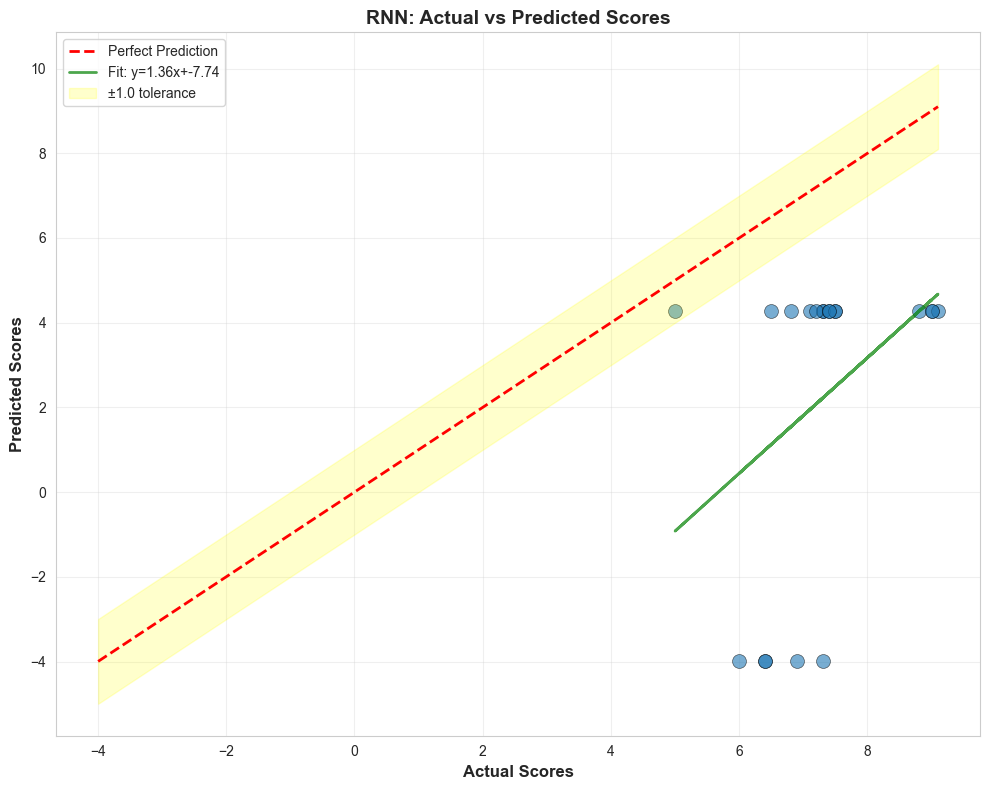

Saved: RNN_residuals.png


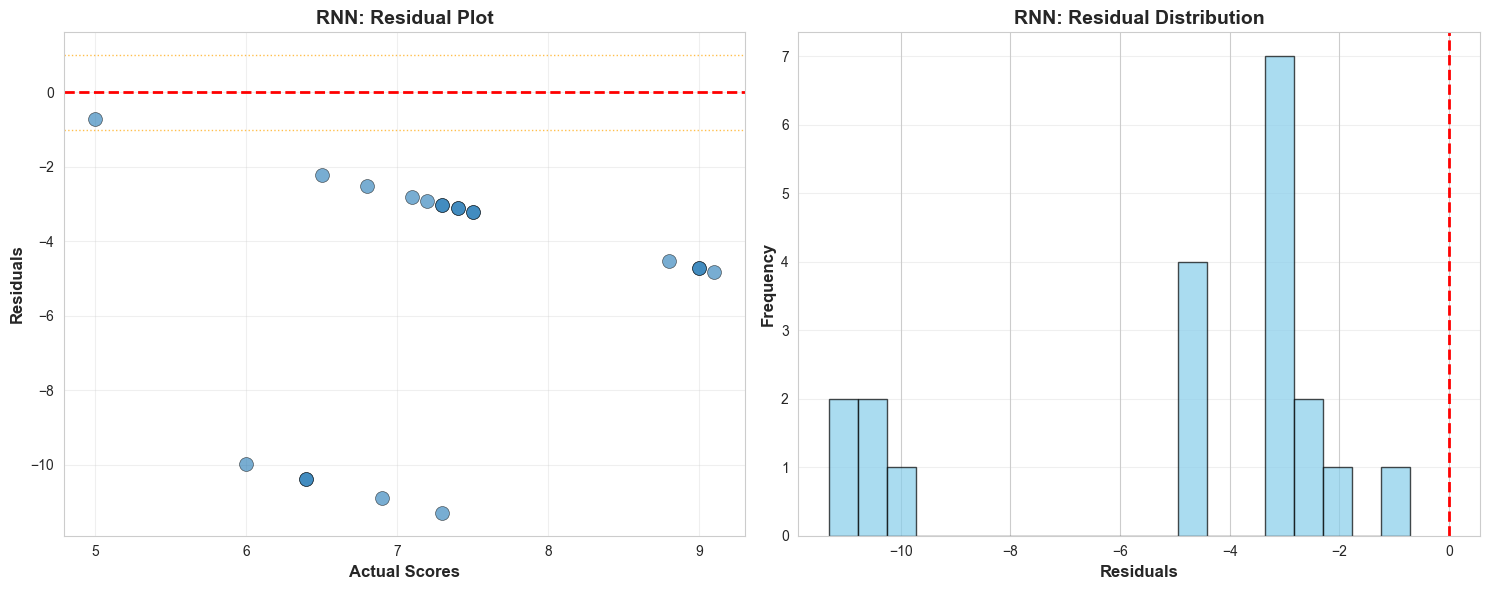


Evaluating BiRNN

Metrics for BiRNN:
  MSE: 0.9337
  RMSE: 0.9663
  MAE: 0.7638
  R²: 0.1137
  Correlation: 0.3776
  Accuracy (±1.0): 65.0000
  Accuracy (±0.5): 50.0000
  BLEU-like Score: 0.7250
Saved: BiRNN_predictions.png


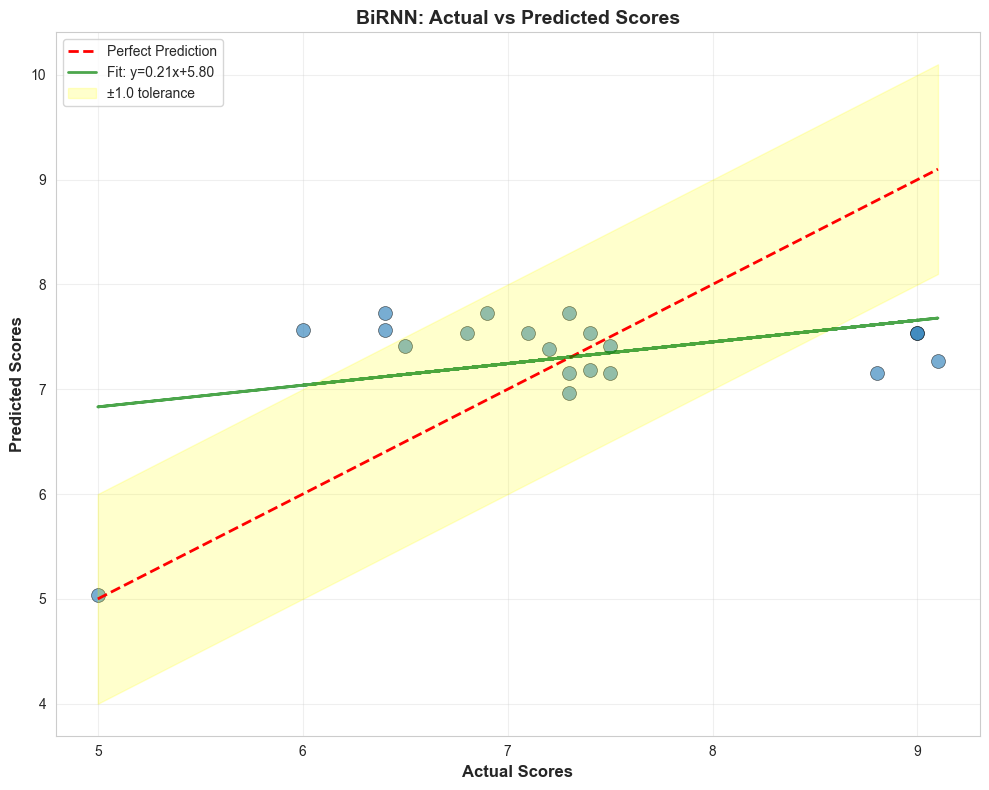

Saved: BiRNN_residuals.png


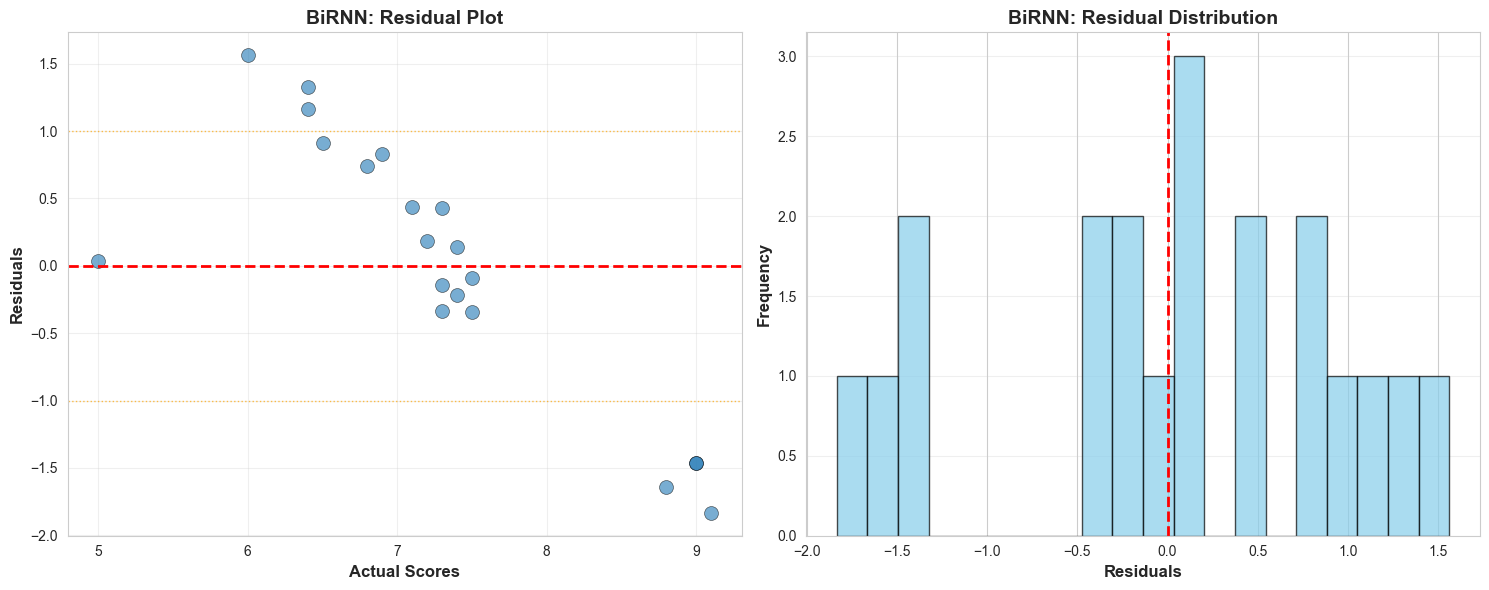


Evaluating GRU

Metrics for GRU:
  MSE: 1.0799
  RMSE: 1.0392
  MAE: 0.7775
  R²: -0.0251
  Correlation: -0.1824
  Accuracy (±1.0): 60.0000
  Accuracy (±0.5): 45.0000
  BLEU-like Score: 0.6730
Saved: GRU_predictions.png


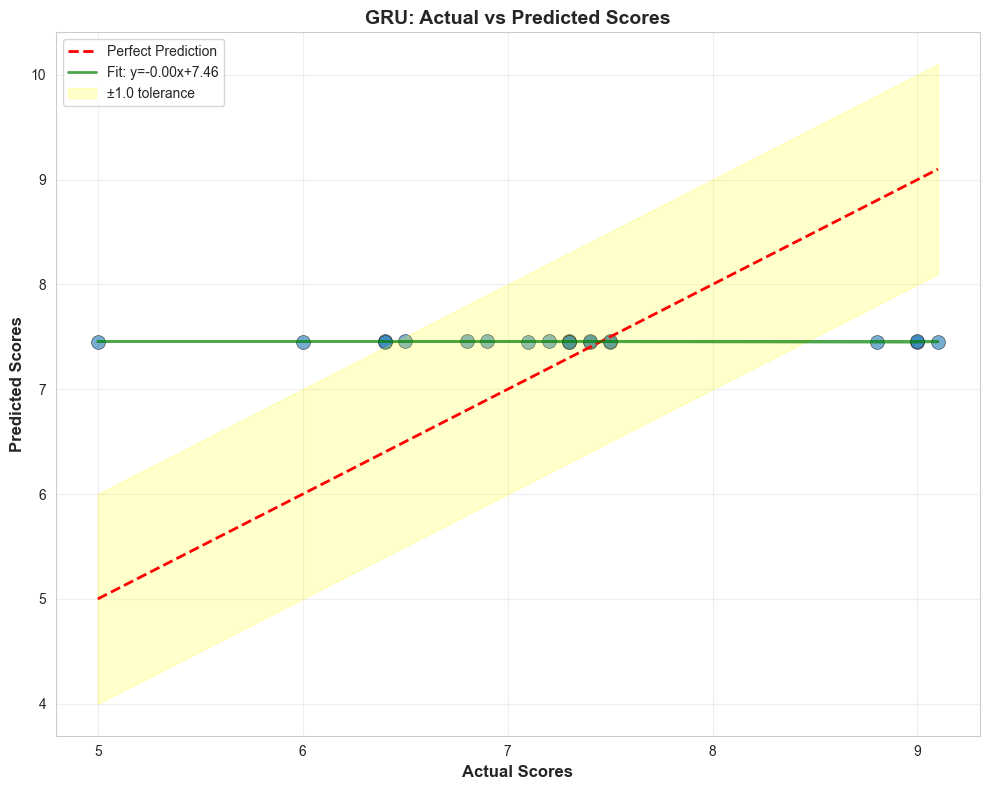

Saved: GRU_residuals.png


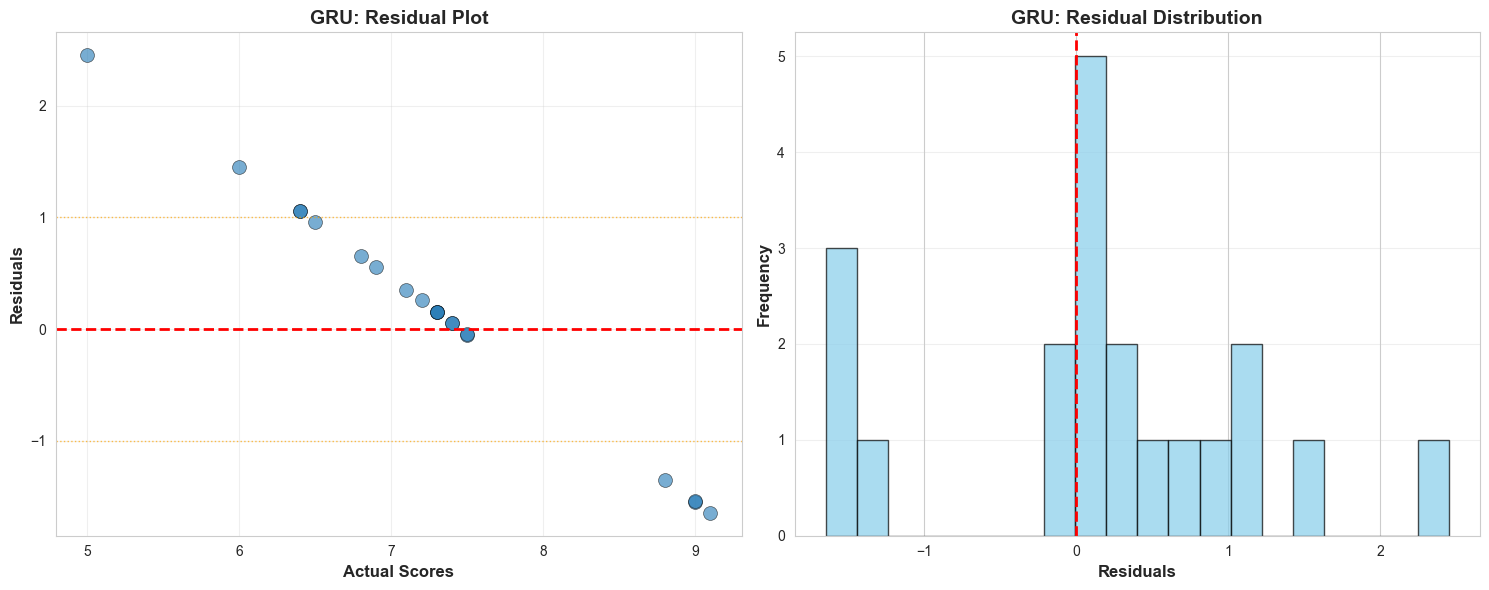


Evaluating LSTM

Metrics for LSTM:
  MSE: 1.0552
  RMSE: 1.0272
  MAE: 0.7395
  R²: -0.0017
  Correlation: -0.4034
  Accuracy (±1.0): 70.0000
  Accuracy (±0.5): 55.0000
  BLEU-like Score: 0.7237
Saved: LSTM_predictions.png


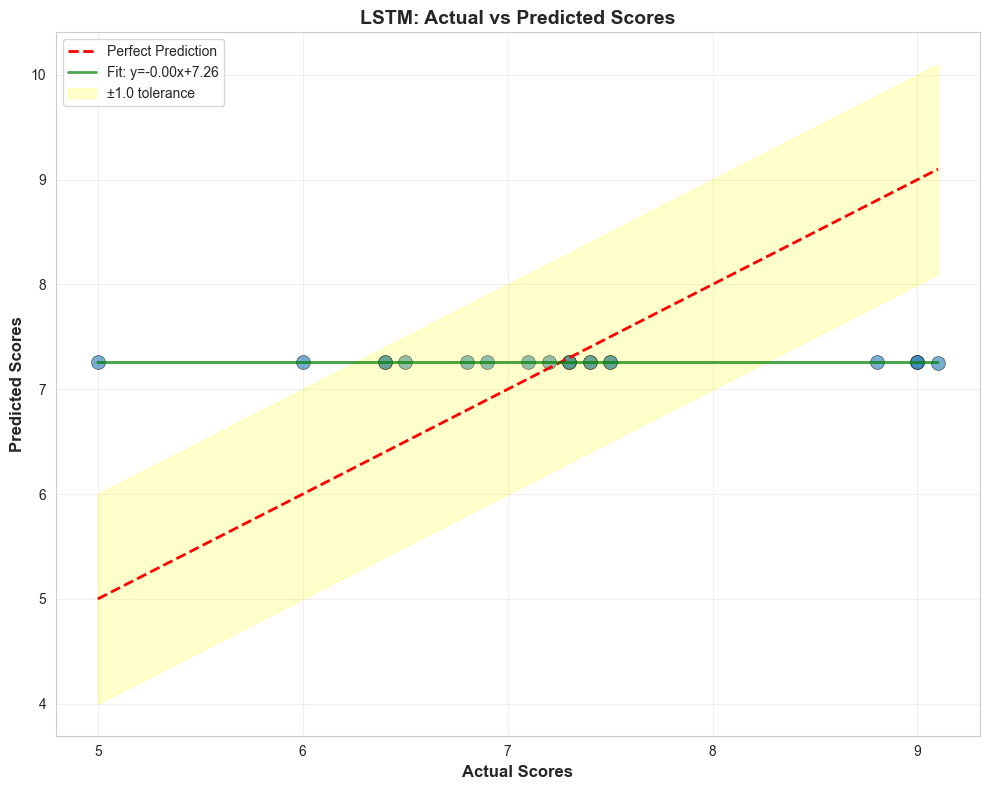

Saved: LSTM_residuals.png


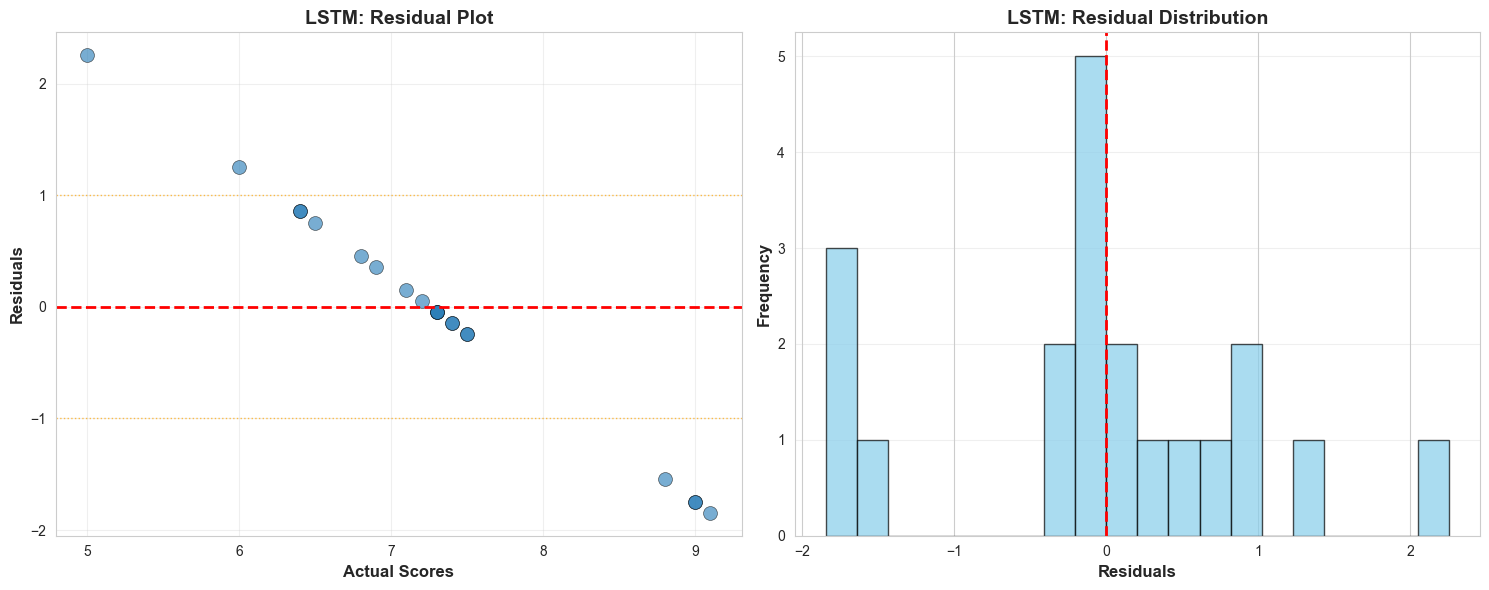


MODEL COMPARISON - ALL METRICS
Model       MSE     RMSE      MAE         R²  Correlation  Accuracy (±1.0)  Accuracy (±0.5)  BLEU-like Score
  RNN 36.873363 6.072344 5.083952 -34.001652     0.390789              5.0              0.0         0.000000
BiRNN  0.933741 0.966303 0.763795   0.113656     0.377599             65.0             50.0         0.724979
  GRU  1.079890 1.039177 0.777476  -0.025074    -0.182361             60.0             45.0         0.673045
 LSTM  1.055225 1.027242 0.739508  -0.001661    -0.403449             70.0             55.0         0.723705

Saved: comprehensive_model_comparison.png


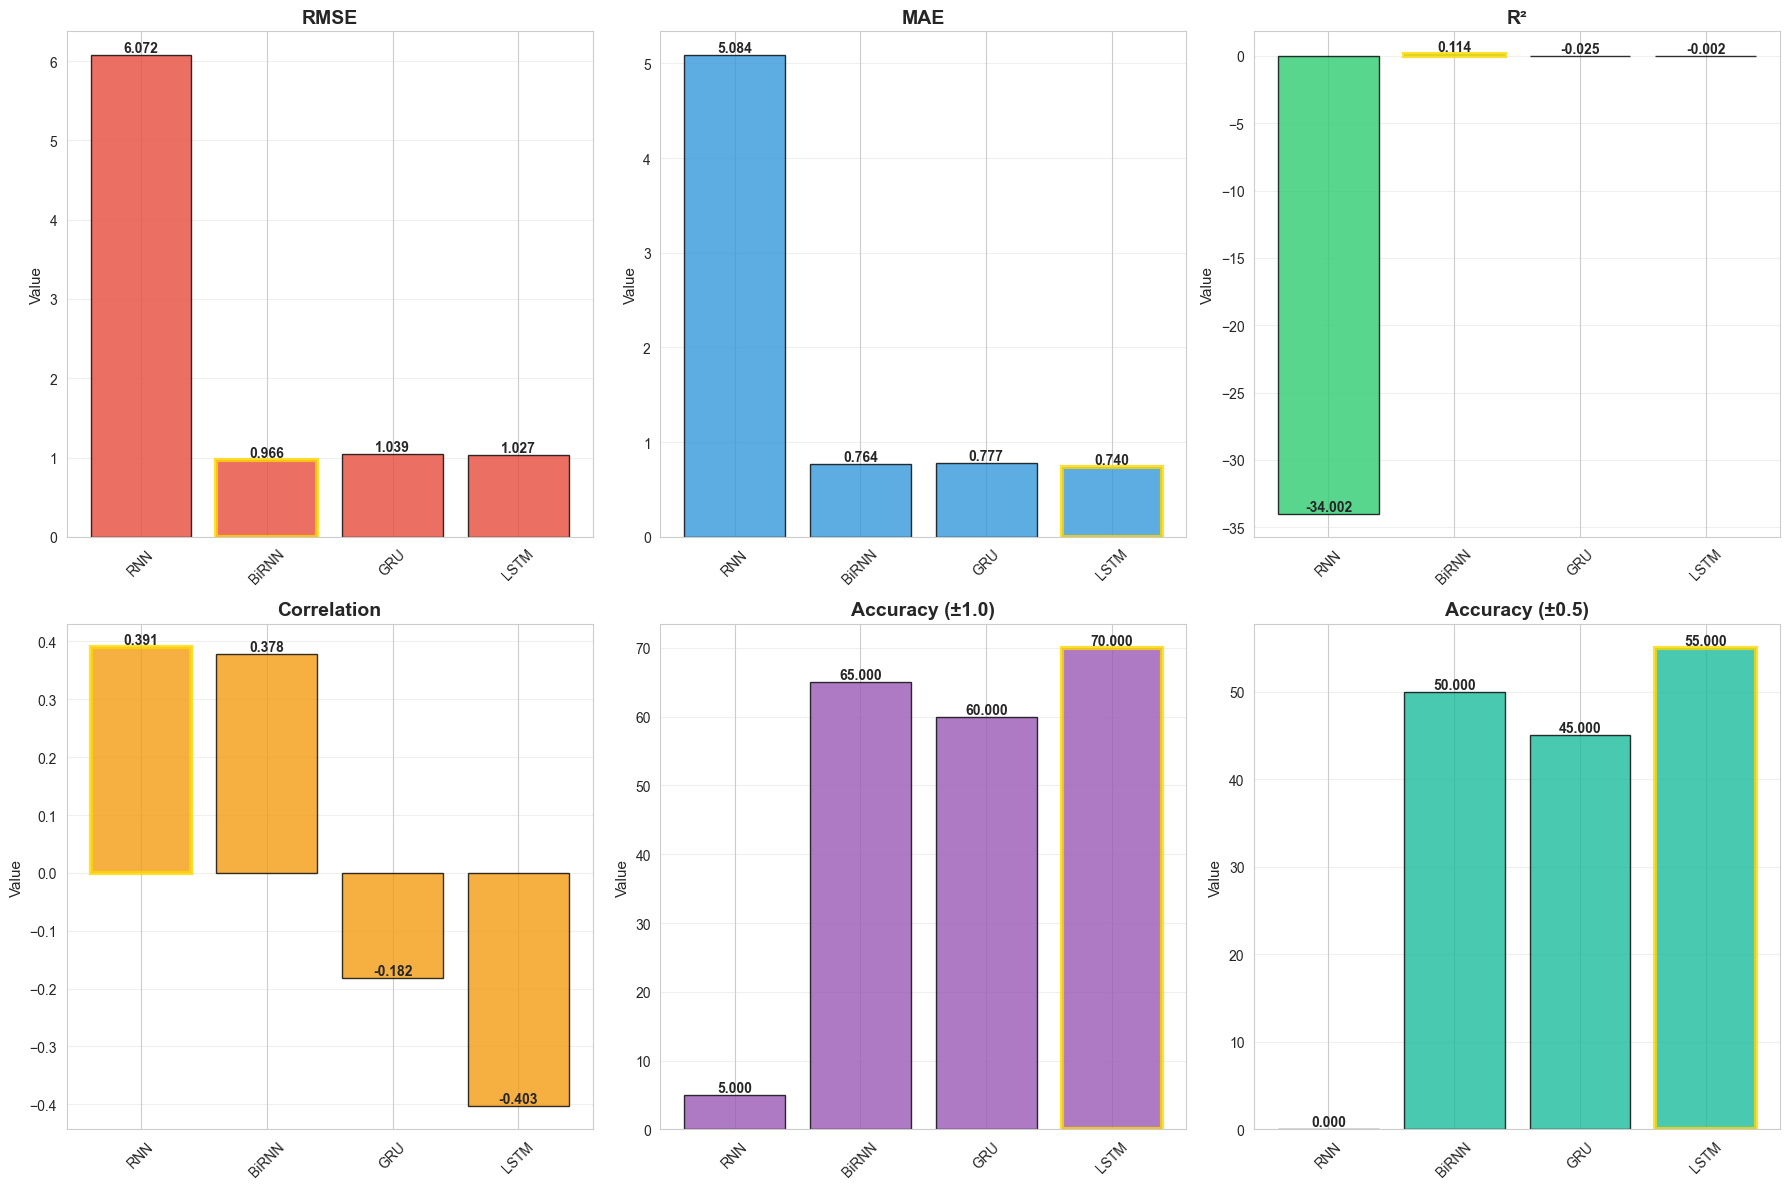

Saved: training_histories_comparison.png


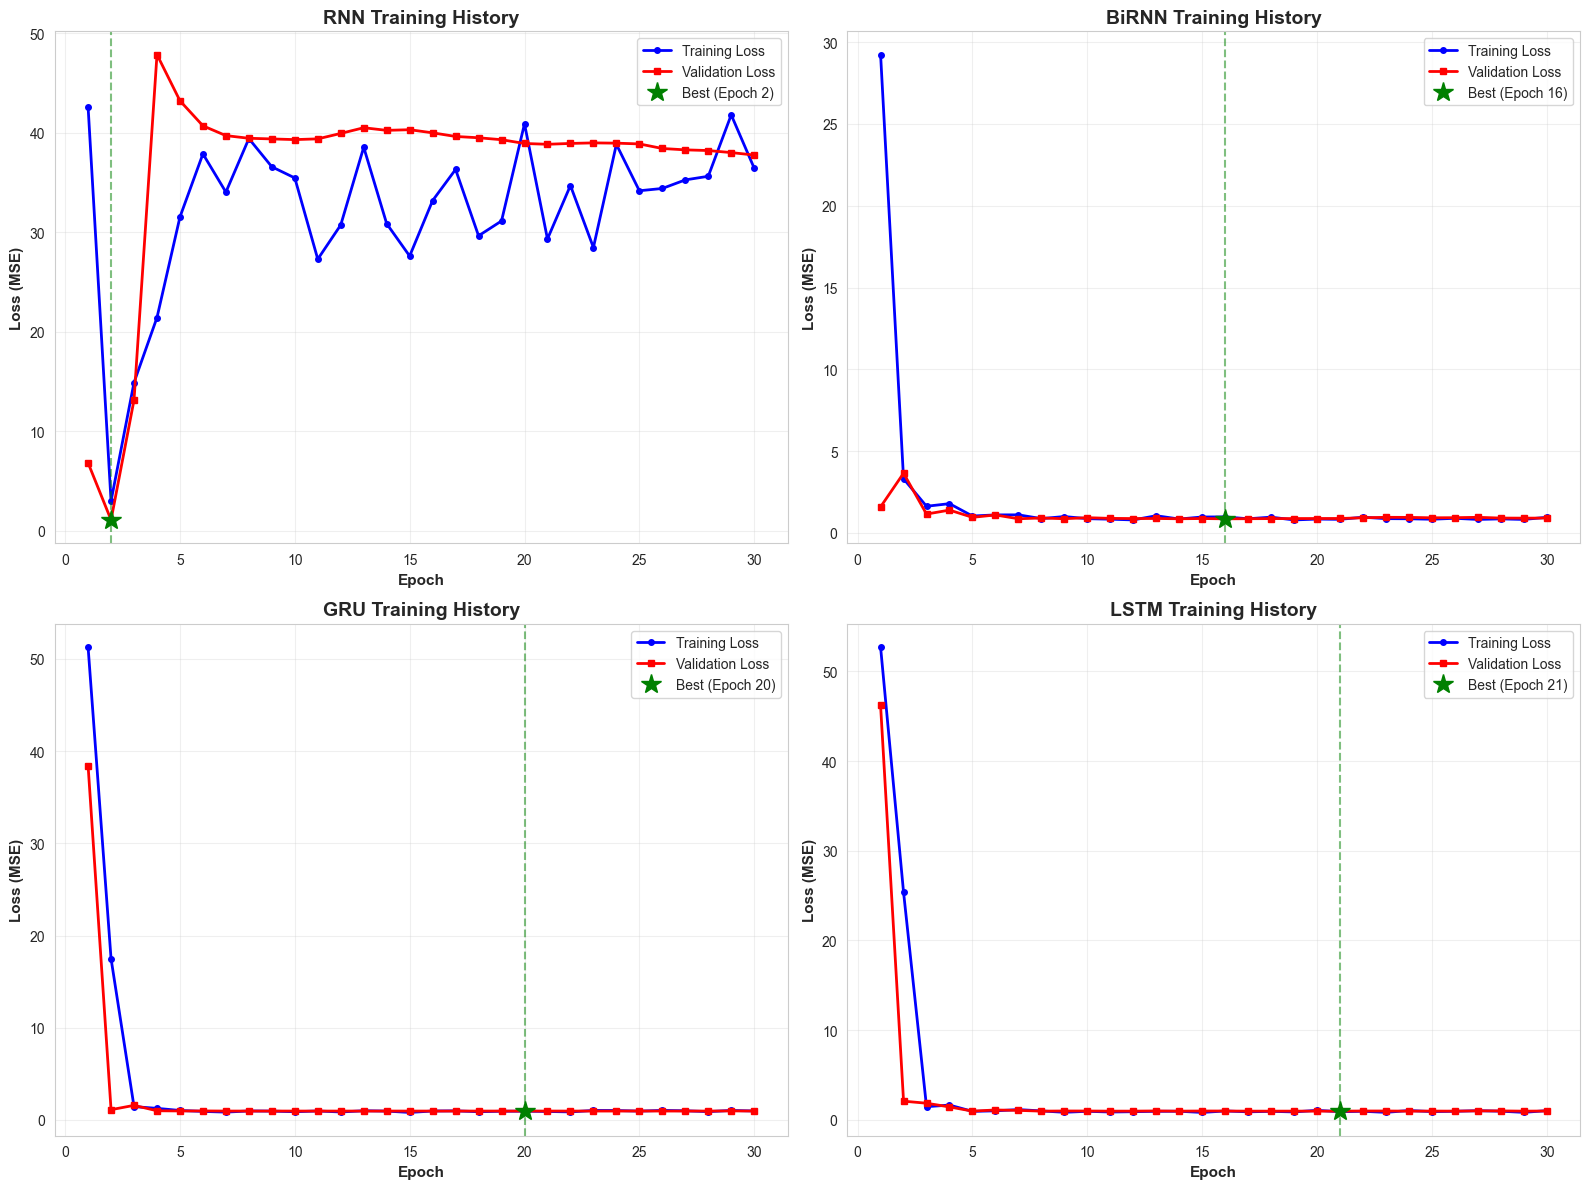


FINAL RECOMMENDATIONS
Best Model (by RMSE): BiRNN
Best Model (by R²): BiRNN

Final comparison saved to: final_model_comparison.csv

COMPLETE PIPELINE FINISHED!

View results in: final_model_comparison.csv
Best performing model: BiRNN



In [4]:
# Step 4: Enhanced Model Evaluation & Hyperparameter Tuning
!pip install seaborn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from itertools import product

# Set style for better plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# ==================== Evaluation Functions ====================

def evaluate_model_detailed(model, test_loader, device, model_name="Model"):
    """Comprehensive model evaluation with multiple metrics"""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for texts, scores in test_loader:
            texts, scores = texts.to(device), scores.to(device)
            preds = model(texts)
            
            # Handle different tensor shapes
            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            
            predictions.extend(preds.cpu().numpy())
            actuals.extend(scores.cpu().numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Calculate comprehensive metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    # Custom accuracy metrics
    accuracy_1 = np.mean(np.abs(predictions - actuals) <= 1.0) * 100
    accuracy_0_5 = np.mean(np.abs(predictions - actuals) <= 0.5) * 100
    
    # Pearson correlation
    correlation = np.corrcoef(actuals, predictions)[0, 1]
    
    metrics = {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Correlation': correlation,
        'Accuracy (±1.0)': accuracy_1,
        'Accuracy (±0.5)': accuracy_0_5
    }
    
    return metrics, predictions, actuals

def calculate_bleu_equivalent(actuals, predictions):
    """
    BLEU-inspired metric for regression tasks
    Measures prediction precision at different tolerance levels
    """
    tolerances = [0.5, 1.0, 1.5, 2.0]
    scores = []
    
    for tol in tolerances:
        precision = np.mean(np.abs(predictions - actuals) <= tol)
        scores.append(precision)
    
    # Geometric mean (similar to BLEU)
    bleu_like = np.prod(scores) ** (1/len(scores))
    
    return bleu_like, scores

# ==================== Visualization Functions ====================

def plot_predictions(actuals, predictions, model_name, save=True):
    """Plot actual vs predicted scores with regression line"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Scatter plot
    ax.scatter(actuals, predictions, alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(actuals.min(), predictions.min())
    max_val = max(actuals.max(), predictions.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Regression line
    z = np.polyfit(actuals, predictions, 1)
    p = np.poly1d(z)
    ax.plot(actuals, p(actuals), 'g-', linewidth=2, alpha=0.7, label=f'Fit: y={z[0]:.2f}x+{z[1]:.2f}')
    
    # Confidence bands (±1 point)
    ax.fill_between([min_val, max_val], [min_val-1, max_val-1], [min_val+1, max_val+1], 
                     alpha=0.2, color='yellow', label='±1.0 tolerance')
    
    ax.set_xlabel('Actual Scores', fontsize=12, fontweight='bold')
    ax.set_ylabel('Predicted Scores', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name}: Actual vs Predicted Scores', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save:
        plt.savefig(f'{model_name}_predictions.png', dpi=300, bbox_inches='tight')
        print(f"Saved: {model_name}_predictions.png")
    plt.show()

def plot_residuals(actuals, predictions, model_name, save=True):
    """Plot residual analysis"""
    residuals = predictions - actuals
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Residual plot
    axes[0].scatter(actuals, residuals, alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
    axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0].axhline(y=1, color='orange', linestyle=':', linewidth=1, alpha=0.7)
    axes[0].axhline(y=-1, color='orange', linestyle=':', linewidth=1, alpha=0.7)
    axes[0].set_xlabel('Actual Scores', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Residuals', fontsize=12, fontweight='bold')
    axes[0].set_title(f'{model_name}: Residual Plot', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Residual distribution
    axes[1].hist(residuals, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
    axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Residuals', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{model_name}: Residual Distribution', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    if save:
        plt.savefig(f'{model_name}_residuals.png', dpi=300, bbox_inches='tight')
        print(f"Saved: {model_name}_residuals.png")
    plt.show()

def compare_all_models(model_results, save=True):
    """Comprehensive model comparison with multiple visualizations"""
    df_results = pd.DataFrame(model_results)
    
    print("\n" + "="*80)
    print("MODEL COMPARISON - ALL METRICS")
    print("="*80)
    print(df_results.to_string(index=False))
    
    # Create comprehensive comparison plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    metrics = ['RMSE', 'MAE', 'R²', 'Correlation', 'Accuracy (±1.0)', 'Accuracy (±0.5)']
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        values = df_results[metric].values
        bars = ax.bar(df_results['Model'], values, color=colors[idx], alpha=0.8, edgecolor='black')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        ax.set_title(metric, fontsize=14, fontweight='bold')
        ax.set_ylabel('Value', fontsize=11)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Highlight best model
        best_idx = values.argmax() if metric in ['R²', 'Correlation', 'Accuracy (±1.0)', 'Accuracy (±0.5)'] else values.argmin()
        bars[best_idx].set_edgecolor('gold')
        bars[best_idx].set_linewidth(3)
    
    plt.tight_layout()
    if save:
        plt.savefig('comprehensive_model_comparison.png', dpi=300, bbox_inches='tight')
        print("\nSaved: comprehensive_model_comparison.png")
    plt.show()
    
    return df_results

def plot_training_comparison(training_histories, save=True):
    """Plot training curves for all models"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, (model_name, history) in enumerate(training_histories.items()):
        train_losses, val_losses = history
        epochs = range(1, len(train_losses) + 1)
        
        ax = axes[idx]
        ax.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss', marker='o', markersize=4)
        ax.plot(epochs, val_losses, 'r-', linewidth=2, label='Validation Loss', marker='s', markersize=4)
        
        # Mark best epoch
        best_epoch = np.argmin(val_losses) + 1
        best_loss = min(val_losses)
        ax.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.5, linewidth=1.5)
        ax.plot(best_epoch, best_loss, 'g*', markersize=15, label=f'Best (Epoch {best_epoch})')
        
        ax.set_title(f'{model_name} Training History', fontsize=14, fontweight='bold')
        ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax.set_ylabel('Loss (MSE)', fontsize=11, fontweight='bold')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save:
        plt.savefig('training_histories_comparison.png', dpi=300, bbox_inches='tight')
        print("Saved: training_histories_comparison.png")
    plt.show()

# ==================== Hyperparameter Tuning ====================

def hyperparameter_search(model_class, vocab_size, train_loader, val_loader, param_grid, epochs=20):
    """
    Grid search for optimal hyperparameters
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print("\n" + "="*80)
    print("HYPERPARAMETER TUNING")
    print("="*80)
    
    # Generate all combinations
    keys = param_grid.keys()
    values = param_grid.values()
    combinations = [dict(zip(keys, v)) for v in product(*values)]
    
    print(f"Testing {len(combinations)} parameter combinations...")
    
    best_val_loss = float('inf')
    best_params = None
    results = []
    
    for idx, params in enumerate(combinations, 1):
        print(f"\n[{idx}/{len(combinations)}] Testing: {params}")
        
        # Create model with current params
        model = model_class(
            vocab_size=vocab_size,
            embedding_dim=params['embedding_dim'],
            hidden_dim=params['hidden_dim'],
            output_dim=1,
            n_layers=params['n_layers'],
            dropout=params['dropout']
        ).to(device)
        
        # Train
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        
        val_losses = []
        for epoch in range(epochs):
            # Training
            model.train()
            for texts, scores in train_loader:
                texts, scores = texts.to(device), scores.to(device)
                optimizer.zero_grad()
                predictions = model(texts)
                loss = criterion(predictions, scores)
                loss.backward()
                optimizer.step()
            
            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for texts, scores in val_loader:
                    texts, scores = texts.to(device), scores.to(device)
                    predictions = model(texts)
                    loss = criterion(predictions, scores)
                    val_loss += loss.item()
            
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
        
        final_val_loss = min(val_losses)
        results.append({**params, 'val_loss': final_val_loss})
        
        print(f"   Final Val Loss: {final_val_loss:.4f}")
        
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_params = params
            print(f"   New best params!")
    
    print("\n" + "="*80)
    print("BEST HYPERPARAMETERS")
    print("="*80)
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Best Parameters: {best_params}")
    
    # Save results
    results_df = pd.DataFrame(results).sort_values('val_loss')
    results_df.to_csv('hyperparameter_search_results.csv', index=False)
    print("\nResults saved to: hyperparameter_search_results.csv")
    
    return best_params, results_df

# ==================== MAIN EVALUATION SCRIPT ====================

def run_complete_evaluation(models_dict, test_loader, training_histories, device):
    """
    Run complete evaluation pipeline
    """
    print("\n" + "="*80)
    print("RUNNING COMPLETE MODEL EVALUATION")
    print("="*80)
    
    all_results = []
    
    for model_name, model in models_dict.items():
        print(f"\n{'='*80}")
        print(f"Evaluating {model_name}")
        print(f"{'='*80}")
        
        # Detailed evaluation
        metrics, predictions, actuals = evaluate_model_detailed(
            model, test_loader, device, model_name
        )
        
        # BLEU-like score
        bleu_like, precision_scores = calculate_bleu_equivalent(actuals, predictions)
        metrics['BLEU-like Score'] = bleu_like
        
        print(f"\nMetrics for {model_name}:")
        for key, value in metrics.items():
            if key != 'Model':
                print(f"  {key}: {value:.4f}")
        
        all_results.append(metrics)
        
        # Generate visualizations
        plot_predictions(actuals, predictions, model_name)
        plot_residuals(actuals, predictions, model_name)
    
    # Compare all models
    comparison_df = compare_all_models(all_results)
    
    # Plot training histories
    plot_training_comparison(training_histories)
    
    # Identify best model
    best_model_by_rmse = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']
    best_model_by_r2 = comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']
    
    print("\n" + "="*80)
    print("FINAL RECOMMENDATIONS")
    print("="*80)
    print(f"Best Model (by RMSE): {best_model_by_rmse}")
    print(f"Best Model (by R²): {best_model_by_r2}")
    
    # Save final results
    comparison_df.to_csv('final_model_comparison.csv', index=False)
    print("\nFinal comparison saved to: final_model_comparison.csv")
    
    return comparison_df, best_model_by_rmse

print("\n" + "="*80)
print("NOW CALLING run_complete_evaluation()...")
print("="*80)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

comparison_df, best_model = run_complete_evaluation(
    models_dict=models,                    # Dictionary of trained models
    test_loader=test_loader,               # Test data loader
    training_histories=training_results,   # Training history (losses)
    device=device                          # CPU or GPU
)

print("\n" + "="*80)
print("COMPLETE PIPELINE FINISHED!")
print("="*80)
print(f"\nView results in: final_model_comparison.csv")
print(f"Best performing model: {best_model}")
print("\n" + "="*80)

In [5]:
# Part 2: GPT-2 Fine-tuning for Arabic Text Generation

# Install required libraries
!pip install transformers torch datasets accelerate -q
!pip install hf_xet
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import logging
import warnings

# Suppress warnings
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings('ignore')

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# ==================== Arabic Text Dataset ====================

class ArabicTextDataset(Dataset):
    """Custom dataset for Arabic text"""
    
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.end_of_text_token = "<|endoftext|>"
        
        # Prepare text sequences
        self.text_list = []
        for text in texts:
            if isinstance(text, str) and len(text.strip()) > 0:
                formatted_text = f"{text}{self.end_of_text_token}"
                self.text_list.append(formatted_text)
        
        print(f"Dataset prepared: {len(self.text_list)} samples")
    
    def __len__(self):
        return len(self.text_list)
    
    def __getitem__(self, idx):
        return self.text_list[idx]


# ==================== Load and Prepare Data ====================

def load_arabic_data(file_path='arabic_dataset_preprocessed.csv'):
    """Load Arabic dataset"""
    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        print(f"Loaded {len(df)} samples from {file_path}")
        
        # Use original text (not preprocessed) for generation
        texts = df['text'].values
        
    except FileNotFoundError:
        print("Dataset not found. Creating sample Arabic tech texts...")
        texts = [
            "التكنولوجيا الحديثة تغير العالم بسرعة كبيرة ومع التطورات المستمرة في مجال الذكاء الاصطناعي",
            "الذكاء الاصطناعي يحدث ثورة في مجال الطب والرعاية الصحية من خلال التشخيص المبكر",
            "البرمجة مهارة أساسية في العصر الحديث ويجب على الجميع تعلم أساسياتها",
            "علم البيانات والتحليلات تساعد الشركات على اتخاذ قرارات أفضل وأكثر دقة",
            "الأمن السيبراني أصبح ضرورة ملحة في عالم متصل بالإنترنت بشكل كامل",
            "الحوسبة السحابية توفر حلولاً مرنة وقابلة للتطوير للشركات من جميع الأحجام",
            "إنترنت الأشياء يربط الأجهزة والأنظمة بطرق لم تكن ممكنة من قبل",
            "تقنية البلوك تشين تعد بإحداث تغيير جذري في كيفية تعاملنا مع البيانات والمعاملات",
        ] * 10  # Repeat to get 80 samples
    
    return texts


# ==================== Model Setup ====================

def setup_gpt2_model(model_name='gpt2'):
    """
    Setup GPT-2 model and tokenizer
    Note: GPT-2 is trained on English, so for production you'd want:
    - arabicgpt2 or aragpt2 (Arabic-specific models)
    - But for learning purposes, we'll use standard GPT-2
    """
    print(f"\n{'='*60}")
    print(f"Loading {model_name} model...")
    print(f"{'='*60}")
    
    # Load tokenizer and model
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)
    
    # Add padding token (GPT-2 doesn't have one by default)
    tokenizer.pad_token = tokenizer.eos_token
    
    model = model.to(device)
    print(f"Model loaded successfully!")
    print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    return tokenizer, model


# ==================== Training Function ====================

def train_gpt2(model, tokenizer, dataset, epochs=5, batch_size=4, 
               learning_rate=3e-5, warmup_steps=100, max_seq_len=512):
    """
    Fine-tune GPT-2 on custom dataset
    """
    print(f"\n{'='*60}")
    print("TRAINING CONFIGURATION")
    print(f"{'='*60}")
    print(f"Epochs: {epochs}")
    print(f"Batch Size: {batch_size}")
    print(f"Learning Rate: {learning_rate}")
    print(f"Max Sequence Length: {max_seq_len}")
    print(f"Warmup Steps: {warmup_steps}")
    
    # Create data loader
    data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Setup optimizer and scheduler
    model.train()
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(data_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    # Training metrics
    proc_seq_count = 0
    sum_loss = 0.0
    batch_count = 0
    
    # Create models folder
    models_folder = "trained_models"
    if not os.path.exists(models_folder):
        os.mkdir(models_folder)
    
    print(f"\n{'='*60}")
    print("STARTING TRAINING")
    print(f"{'='*60}")
    
    # Training loop
    for epoch in range(epochs):
        print(f"\n{'='*50}")
        print(f"EPOCH {epoch + 1}/{epochs}")
        print(f"{'='*50}")
        
        epoch_loss = 0.0
        tmp_text_tens = None
        
        for idx, text in enumerate(data_loader):
            # Tokenize text
            text_tens = torch.tensor(
                tokenizer.encode(text[0])
            ).unsqueeze(0).to(device)
            
            # Skip if too long
            if text_tens.size()[1] > max_seq_len:
                continue
            
            # Batch sequences together
            if not torch.is_tensor(tmp_text_tens):
                tmp_text_tens = text_tens
                continue
            else:
                # Process batch if adding new text exceeds max length
                if tmp_text_tens.size()[1] + text_tens.size()[1] > max_seq_len:
                    work_text_tens = tmp_text_tens
                    tmp_text_tens = text_tens
                else:
                    # Concatenate texts
                    tmp_text_tens = torch.cat(
                        [tmp_text_tens, text_tens[:, 1:]], dim=1
                    )
                    continue
            
            # Forward pass
            outputs = model(work_text_tens, labels=work_text_tens)
            loss, logits = outputs[:2]
            
            # Backward pass
            loss.backward()
            sum_loss += loss.detach().item()
            epoch_loss += loss.detach().item()
            proc_seq_count += 1
            
            # Update weights after accumulating batch_size samples
            if proc_seq_count == batch_size:
                proc_seq_count = 0
                batch_count += 1
                
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                model.zero_grad()
                
                # Print progress
                if batch_count % 10 == 0:
                    avg_loss = sum_loss / 10
                    print(f"  Batch {batch_count} | Loss: {avg_loss:.4f}")
                    sum_loss = 0.0
        
        # Save model after each epoch
        model_path = os.path.join(models_folder, f"gpt2_arabic_epoch_{epoch}.pt")
        torch.save(model.state_dict(), model_path)
        print(f"\nEpoch {epoch + 1} completed")
        print(f"   Average Loss: {epoch_loss / len(data_loader):.4f}")
        print(f"   Model saved: {model_path}")
    
    print(f"\n{'='*60}")
    print("TRAINING COMPLETED!")
    print(f"{'='*60}")
    
    return model


# ==================== Text Generation ====================

def choose_from_top(probs, n=5):
    """Sample from top-n probabilities"""
    ind = np.argpartition(probs, -n)[-n:]
    top_prob = probs[ind]
    top_prob = top_prob / np.sum(top_prob)  # Normalize
    choice = np.random.choice(n, 1, p=top_prob)
    token_id = ind[choice][0]
    return int(token_id)


def generate_text(model, tokenizer, prompt="التكنولوجيا", 
                  max_length=100, num_samples=5, temperature=1.0):
    """
    Generate text using fine-tuned model
    """
    print(f"\n{'='*60}")
    print(f"GENERATING TEXT")
    print(f"{'='*60}")
    print(f"Prompt: '{prompt}'")
    print(f"Samples: {num_samples}")
    print(f"Max Length: {max_length} tokens")
    print(f"{'='*60}\n")
    
    model.eval()
    generated_texts = []
    
    with torch.no_grad():
        for sample_idx in range(num_samples):
            # Encode prompt
            cur_ids = torch.tensor(
                tokenizer.encode(prompt)
            ).unsqueeze(0).to(device)
            
            text_finished = False
            
            for i in range(max_length):
                # Get model predictions
                outputs = model(cur_ids, labels=cur_ids)
                loss, logits = outputs[:2]
                
                # Apply temperature and softmax
                softmax_logits = torch.softmax(
                    logits[0, -1] / temperature, dim=0
                )
                
                # Sample next token
                if i < 3:
                    n = 20  # More exploration at start
                else:
                    n = 5   # More focused later
                
                next_token_id = choose_from_top(
                    softmax_logits.to('cpu').numpy(), n=n
                )
                
                # Add token to sequence
                cur_ids = torch.cat([
                    cur_ids,
                    torch.ones((1, 1)).long().to(device) * next_token_id
                ], dim=1)
                
                # Check if finished
                if next_token_id in tokenizer.encode('<|endoftext|>'):
                    text_finished = True
                    break
            
            # Decode generated text
            output_list = list(cur_ids.squeeze().to('cpu').numpy())
            output_text = tokenizer.decode(output_list)
            
            # Clean output
            output_text = output_text.replace('<|endoftext|>', '').strip()
            
            generated_texts.append(output_text)
            
            print(f"Sample {sample_idx + 1}:")
            print(f"{output_text}")
            print(f"{'-'*60}\n")
    
    return generated_texts


# ==================== MAIN EXECUTION ====================

def main():
    """Main execution pipeline"""
    
    # 1. Load data
    print("="*60)
    print("STEP 1: LOADING DATA")
    print("="*60)
    texts = load_arabic_data()
    
    # 2. Setup model
    print("\n" + "="*60)
    print("STEP 2: SETTING UP MODEL")
    print("="*60)
    tokenizer, model = setup_gpt2_model('gpt2')  # Use 'gpt2-medium' for better results
    
    # 3. Create dataset
    print("\n" + "="*60)
    print("STEP 3: PREPARING DATASET")
    print("="*60)
    dataset = ArabicTextDataset(texts, tokenizer, max_length=512)
    
    # 4. Train model
    print("\n" + "="*60)
    print("STEP 4: FINE-TUNING MODEL")
    print("="*60)
    model = train_gpt2(
        model=model,
        tokenizer=tokenizer,
        dataset=dataset,
        epochs=3,  # Increase for better results
        batch_size=4,
        learning_rate=3e-5,
        warmup_steps=100,
        max_seq_len=512
    )
    
    # 5. Generate text
    print("\n" + "="*60)
    print("STEP 5: GENERATING TEXT")
    print("="*60)
    
    # Test with different prompts
    prompts = [
        "التكنولوجيا",
        "الذكاء الاصطناعي",
        "البرمجة"
    ]
    
    all_generated = {}
    for prompt in prompts:
        generated = generate_text(
            model=model,
            tokenizer=tokenizer,
            prompt=prompt,
            max_length=50,
            num_samples=3,
            temperature=0.8
        )
        all_generated[prompt] = generated
    
    # 6. Save results
    print("\n" + "="*60)
    print("SAVING RESULTS")
    print("="*60)
    
    output_file = 'generated_arabic_texts.txt'
    with open(output_file, 'w', encoding='utf-8') as f:
        for prompt, texts in all_generated.items():
            f.write(f"Prompt: {prompt}\n")
            f.write("="*60 + "\n\n")
            for idx, text in enumerate(texts, 1):
                f.write(f"Sample {idx}:\n{text}\n\n")
            f.write("\n" + "="*60 + "\n\n")
    
    print(f"Generated texts saved to: {output_file}")
    
    print("\n" + "="*60)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*60)


# ==================== LOAD EXISTING MODEL ====================

def load_trained_model(epoch=2):
    """Load a previously trained model"""
    print(f"Loading model from epoch {epoch}...")
    
    tokenizer, model = setup_gpt2_model('gpt2')
    model_path = f"trained_models/gpt2_arabic_epoch_{epoch}.pt"
    
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Model loaded from {model_path}")
    else:
        print(f"Model not found: {model_path}")
        return None, None
    
    return tokenizer, model


# ==================== RUN EVERYTHING ====================

if __name__ == "__main__":
    main()
    
    # Or generate text from a saved model:
    # tokenizer, model = load_trained_model(epoch=2)
    # if model:
    #     generate_text(model, tokenizer, prompt="الذكاء الاصطناعي")



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 2.9/2.9 MB 2.6 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\Niama Aqarial\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
STEP 1: LOADING DATA
Loaded 100 samples from arabic_dataset_preprocessed.csv

STEP 2: SETTING UP MODEL

Loading gpt2 model...
Model loaded successfully!
   Parameters: 124,439,808

STEP 3: PREPARING DATASET
Dataset prepared: 100 samples

STEP 4: FINE-TUNING MODEL

TRAINING CONFIGURATION
Epochs: 3
Batch Size: 4
Learning Rate: 3e-05
Max Sequence Length: 512
Warmup Steps: 100

STARTING TRAINING

EPOCH 1/3


Token indices sequence length is longer than the specified maximum sequence length for this model (2939 > 1024). Running this sequence through the model will result in indexing errors



Epoch 1 completed
   Average Loss: 0.5238
   Model saved: trained_models\gpt2_arabic_epoch_0.pt

EPOCH 2/3
  Batch 10 | Loss: 8.9314

Epoch 2 completed
   Average Loss: 0.4931
   Model saved: trained_models\gpt2_arabic_epoch_1.pt

EPOCH 3/3

Epoch 3 completed
   Average Loss: 0.4390
   Model saved: trained_models\gpt2_arabic_epoch_2.pt

TRAINING COMPLETED!

STEP 5: GENERATING TEXT

GENERATING TEXT
Prompt: 'التكنولوجيا'
Samples: 3
Max Length: 50 tokens

Sample 1:
التكنولوجيام في عبدية مسلم في عبدية بالتكنولوجيام في عبدية مسل
------------------------------------------------------------

Sample 2:
التكنولوجيا بيتشزم بالتكنولوجي بالتكنولوجي بالتكنولوجي ب
------------------------------------------------------------

Sample 3:
التكنولوجيا لا يجمراء كني عليه وأصلى وأستكنولوجيا وحمده و
------------------------------------------------------------


GENERATING TEXT
Prompt: 'الذكاء الاصطناعي'
Samples: 3
Max Length: 50 tokens

Sample 1:
الذكاء الاصطناعي السادرة الشريزي القالمان، بقالمان بصطناعي ا